In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [12]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [13]:
class Autoencoder(tfk.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(512, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(256, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(128, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(128, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(256, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(512, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1D(1, kernel_size = 3, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
class Conv1D(tfk.Model):
    def __init__(self):
        super(Conv1D, self).__init__()
        self.conv1D_model = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
            
    def call(self, x):
        conv1D = self.conv1D_model(x)
        return conv1D

In [15]:
cnn1D_encoder_result = {}
for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 24s 17ms/step - loss: 0.2461 - accuracy: 0.9632 - root_mean_squared_error: 0.4961 - val_loss: 0.2510 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5010
Epoch 2/30
200/200 [==============================] - 3s 15ms/step - loss: 0.2125 - accuracy: 1.0000 - root_mean_squared_error: 0.4609 - val_loss: 0.2651 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5149
Epoch 3/30
200/200 [==============================] - 3s 15ms/step - loss: 0.1031 - accuracy: 1.0000 - root_mean_squared_error: 0.3211 - val_loss: 0.3619 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.6016
Epoch 4/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0332 - accuracy: 1.0000 - root_mean_squared_error: 0.1822 - val_loss: 0.4412 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.6643
Epoch 5/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0181 - accuracy: 1.0000 - root_mean_squared_error: 0.1346 - va

200/200 [==============================] - 3s 15ms/step - loss: 0.0142 - accuracy: 1.0000 - root_mean_squared_error: 0.1190 - val_loss: 0.5036 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.7096
Epoch 7/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0120 - accuracy: 1.0000 - root_mean_squared_error: 0.1094 - val_loss: 0.5098 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.7140uracy: 1.0000 - root_mean_squared_err
Epoch 8/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0109 - accuracy: 1.0000 - root_mean_squared_error: 0.1044 - val_loss: 0.5204 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.7214
Epoch 9/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0103 - accuracy: 1.0000 - root_mean_squared_error: 0.1015 - val_loss: 0.5215 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.7222: 0.0101 - accuracy: 1.0000 - root_mean_squ - ETA: 0s - loss: 0.0103 - accuracy: 1.0000 - root_mean_squared_err
Epo

200/200 [==============================] - 3s 15ms/step - loss: 0.0102 - accuracy: 1.0000 - root_mean_squared_error: 0.1012 - val_loss: 0.5095 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7138
Epoch 10/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0101 - accuracy: 1.0000 - root_mean_squared_error: 0.1004 - val_loss: 0.5133 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7165
Epoch 11/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0094 - accuracy: 1.0000 - root_mean_squared_error: 0.0970 - val_loss: 0.5149 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7175
Epoch 12/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0092 - accuracy: 1.0000 - root_mean_squared_error: 0.0959 - val_loss: 0.5207 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7216
Epoch 13/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0085 - accuracy: 1.0000 - root_mean_squared_error: 0.0921 - val_loss: 

200/200 [==============================] - 3s 14ms/step - loss: 0.0085 - accuracy: 1.0000 - root_mean_squared_error: 0.0922 - val_loss: 0.5222 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7226
Epoch 13/30
200/200 [==============================] - 3s 14ms/step - loss: 0.0081 - accuracy: 1.0000 - root_mean_squared_error: 0.0901 - val_loss: 0.5273 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7261
Epoch 14/30
200/200 [==============================] - 3s 14ms/step - loss: 0.0075 - accuracy: 1.0000 - root_mean_squared_error: 0.0865 - val_loss: 0.5278 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7265
Epoch 15/30
200/200 [==============================] - 3s 14ms/step - loss: 0.0072 - accuracy: 1.0000 - root_mean_squared_error: 0.0849 - val_loss: 0.5316 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7291
Epoch 16/30
200/200 [==============================] - 3s 14ms/step - loss: 0.0068 - accuracy: 1.0000 - root_mean_squared_error: 0.0825 - val_loss: 

,0,1,2,3
loss,"[0.24609646201133728, 0.21247047185897827, 0.1...","[0.2465948462486267, 0.21447797119617462, 0.10...","[0.2466634213924408, 0.21225105226039886, 0.09...","[0.2487950176000595, 0.2287336140871048, 0.130..."
accuracy,"[0.9631933569908142, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9424804449081421, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9052392840385437, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.7727636694908142, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.49608108401298523, 0.460945188999176, 0.321...","[0.49658316373825073, 0.46311765909194946, 0.3...","[0.496652215719223, 0.4607071280479431, 0.3082...","[0.4987935721874237, 0.4782610237598419, 0.361..."
val_loss,"[0.25095686316490173, 0.26507267355918884, 0.3...","[0.2508987784385681, 0.2645763158798218, 0.366...","[0.25056546926498413, 0.26415106654167175, 0.3...","[0.2503221333026886, 0.257272332906723, 0.3362..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5009559392929077, 0.5148520469665527, 0.601...","[0.5008979439735413, 0.5143698453903198, 0.605...","[0.5005651116371155, 0.5139562487602234, 0.603...","[0.5003219842910767, 0.5072202086448669, 0.579..."


In [16]:
cnnv1D_result = {}
for i in range(NFOLD-1):
    conv1D = Conv1D()
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 2s 7ms/step - loss: 0.2122 - accuracy: 0.9994 - root_mean_squared_error: 0.4607 - val_loss: 0.2575 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5075
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1896 - accuracy: 1.0000 - root_mean_squared_error: 0.4354 - val_loss: 0.2638 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5136
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1648 - accuracy: 1.0000 - root_mean_squared_error: 0.4059 - val_loss: 0.2726 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5221
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1388 - accuracy: 1.0000 - root_mean_squared_error: 0.3725 - val_loss: 0.2859 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5347
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1134 - accuracy: 1.0000 - root_mean_squared_error: 0.3367 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.0359 - accuracy: 1.0000 - root_mean_squared_error: 0.1896 - val_loss: 0.4058 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6370
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0284 - accuracy: 1.0000 - root_mean_squared_error: 0.1687 - val_loss: 0.4244 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6515
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0231 - accuracy: 1.0000 - root_mean_squared_error: 0.1520 - val_loss: 0.4367 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6608
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0207 - accuracy: 1.0000 - root_mean_squared_error: 0.1439 - val_loss: 0.4529 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6730
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0169 - accuracy: 1.0000 - root_mean_squared_error: 0.1301 - val_loss: 0.461

200/200 [==============================] - 1s 7ms/step - loss: 0.0131 - accuracy: 1.0000 - root_mean_squared_error: 0.1144 - val_loss: 0.4678 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6840
Epoch 18/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0134 - accuracy: 1.0000 - root_mean_squared_error: 0.1157 - val_loss: 0.4774 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6909
Epoch 19/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0132 - accuracy: 1.0000 - root_mean_squared_error: 0.1149 - val_loss: 0.4814 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6938
Epoch 20/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0112 - accuracy: 1.0000 - root_mean_squared_error: 0.1059 - val_loss: 0.4844 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6960
Epoch 21/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0112 - accuracy: 1.0000 - root_mean_squared_error: 0.1059 - val_loss: 0.490

200/200 [==============================] - 1s 6ms/step - loss: 0.0091 - accuracy: 1.0000 - root_mean_squared_error: 0.0954 - val_loss: 0.5114 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7151
Epoch 26/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0094 - accuracy: 1.0000 - root_mean_squared_error: 0.0967 - val_loss: 0.5153 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7179
Epoch 27/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0099 - accuracy: 1.0000 - root_mean_squared_error: 0.0997 - val_loss: 0.5142 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7171
Epoch 28/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0084 - accuracy: 1.0000 - root_mean_squared_error: 0.0914 - val_loss: 0.5171 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7191
Epoch 29/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0091 - accuracy: 1.0000 - root_mean_squared_error: 0.0954 - val_loss: 0.525

,0,1,2,3
loss,"[0.2122398316860199, 0.18961136043071747, 0.16...","[0.20813149213790894, 0.18694829940795898, 0.1...","[0.2697455883026123, 0.2379133254289627, 0.204...","[0.16383926570415497, 0.14051060378551483, 0.1..."
accuracy,"[0.9993749856948853, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9998437762260437, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.043437499552965164, 0.87890625, 1.0, 1.0, 1...","[0.9993749856948853, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.46069493889808655, 0.43544384837150574, 0.4...","[0.4562143087387085, 0.4323751926422119, 0.402...","[0.5193703770637512, 0.48776358366012573, 0.45...","[0.4047706425189972, 0.3748474419116974, 0.343..."
val_loss,"[0.257519394159317, 0.2638096809387207, 0.2725...","[0.25939807295799255, 0.2647000253200531, 0.27...","[0.24978023767471313, 0.25284668803215027, 0.2...","[0.27145540714263916, 0.2848913371562958, 0.29..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.525337815284729, 0.46621620655059814, 0.466...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5074636936187744, 0.5136240720748901, 0.522...","[0.5093113780021667, 0.5144900679588318, 0.525...","[0.49978017807006836, 0.5028386116027832, 0.50...","[0.5210137963294983, 0.5337521433830261, 0.543..."


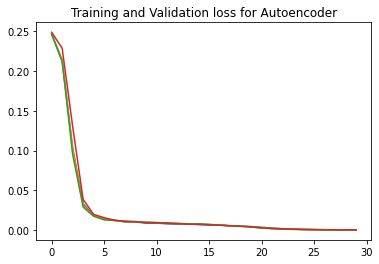

In [17]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    plt.plot(loss)
    plt.title('Training and Validation loss for Autoencoder')

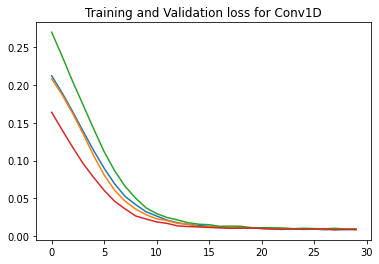

In [18]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    plt.plot(loss)
    plt.title('Training and Validation loss for Conv1D')

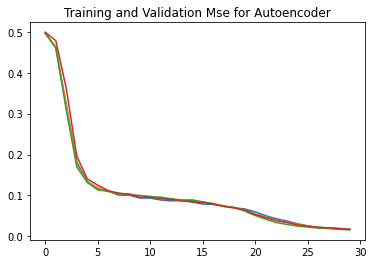

In [19]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training and Validation Mse for Autoencoder')

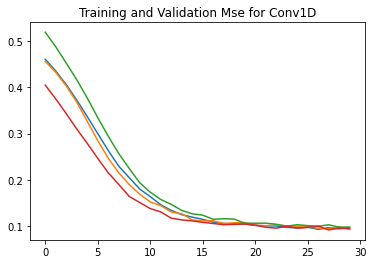

In [20]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training and Validation Mse for Conv1D')

26/26 [==============================] - 1s 5ms/step


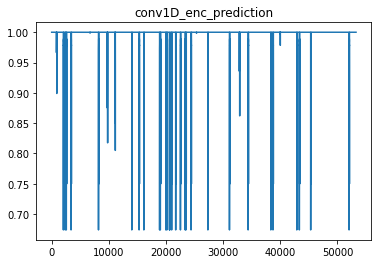

In [21]:
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
cnn1D_enc_predict = cnn1D_enc_predict.reshape(-1)
plt.title("conv1D_enc_prediction")
plt.plot(cnn1D_enc_predict)

53248


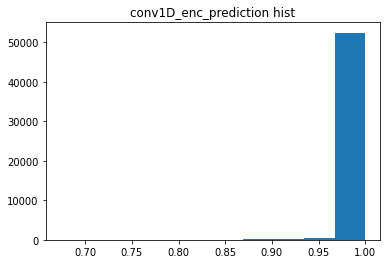

In [22]:
plt.title("conv1D_enc_prediction hist")
plt.hist(cnn1D_enc_predict)
print(cnn1D_enc_predict.size)

26/26 [==============================] - 0s 2ms/step


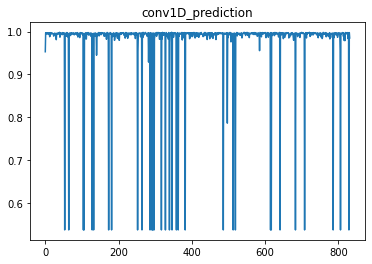

In [23]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("conv1D_prediction")
plt.plot(conv1D_predict)

832


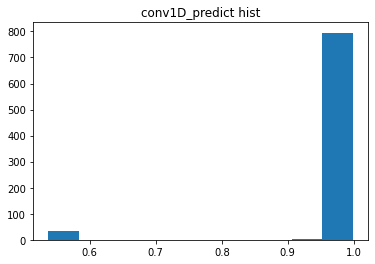

In [24]:
plt.title("conv1D_predict hist")
plt.hist(conv1D_predict)
print(conv1D_predict.size)